# Starting Over
I'm going to experiment with filtering out low review scores while keeping users with at least 3+ reviews. This will filter out most of the noise that we don't want in our dataset.

In [33]:
import numpy as np
import pandas as pd

from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
df = pd.read_csv('metacriticfortuning.csv', index_col='Unnamed: 0')

In [35]:
df.head()

,is_critic,reviewer_name,reviewer_score,url,title,norm_score,genre,reviewer_id
0,1,GamingXP,35,007-legends,007 Legends (PC),4,"Action, Shooter, First-Person, Modern, Arcade",0
1,1,GamingXP,35,007-legends,007 Legends (PC),4,"Action, Shooter, First-Person, Modern, Arcade",0
2,1,GamingXP,35,007-legends,007 Legends (PC),4,"Action, Shooter, First-Person, Modern, Arcade",0
3,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
4,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0


In [36]:
df.shape

(221303, 8)

## First we keep only the reviews with a score greater than 5

In [37]:
df = df[df['norm_score'].values > 5] ###### THIS WAS SET TO 4

In [38]:
df.shape # We've lost quite a few bad reviews... let's see how this works.

(163428, 8)

## We also want to keep only the users with 4 or more reviews...

In [39]:
df = df.groupby('reviewer_id').filter(lambda x: len(x) > 3)

In [40]:
#New Dataset has an average of 2.59 reviews per person...
print "average reviews per person:"
print np.mean(df.reviewer_id.value_counts())
print
#New Dataset has 221303 reviews...
print "length of dataframe:"
print len(df)
print
#New Dataset has 85371 reviewers...
print "top reviewers:"
print df.reviewer_id.value_counts()

average reviews per person:
21.6808606006

length of dataframe:
96740

top reviewers:
34       2147
37       2001
4        1938
30       1308
87       1066
61        966
36        943
1         838
196       803
188       785
158       767
33        755
59        742
189       742
79        719
148       716
159       708
41        704
354       704
62        692
142       690
82        649
38        645
57        637
40        634
81        613
63        609
270       600
167       579
547       570
         ... 
16148       4
1939        4
22833       4
39232       4
9558        4
23606       4
11735       4
4521        4
15610       4
10606       4
16021       4
1746        4
11991       4
5904        4
18266       4
30556       4
38784       4
42886       4
41279       4
26918       4
20443       4
52452       4
18458       4
47172       4
8279        4
12525       4
7294        4
211         4
18594       4
18072       4
Name: reviewer_id, Length: 4462, dtype: int64


In [41]:
df.head()

,is_critic,reviewer_name,reviewer_score,url,title,norm_score,genre,reviewer_id
3,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
4,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
5,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
6,1,GamingXP,72,a-game-of-thrones-genesis,A Game of Thrones: Genesis (PC),7,"Strategy, Real-Time, General, Historic, Fantas...",0
7,1,GamingXP,85,a-new-beginning-final-cut,A New Beginning: Final Cut (PC),9,"Adventure, General, General",0


## Need to fix the index and reviewer_id since they are now missing values...
When we dropped some reviews and reviewrs we need to re-index the dataframe.

In [42]:
df = df.reset_index()
df = df.drop(['index'], axis=1)

In [43]:
df.head() #Our dataframe is looking nice and orderly again...

,is_critic,reviewer_name,reviewer_score,url,title,norm_score,genre,reviewer_id
0,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
1,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
2,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
3,1,GamingXP,72,a-game-of-thrones-genesis,A Game of Thrones: Genesis (PC),7,"Strategy, Real-Time, General, Historic, Fantas...",0
4,1,GamingXP,85,a-new-beginning-final-cut,A New Beginning: Final Cut (PC),9,"Adventure, General, General",0


In [44]:
#Build a df to make a new reviewer_id so we don't have any empty spaces...
revName = pd.DataFrame(df['reviewer_name'].unique())

revName.columns = ['reviewer_name']
revName['reviewer_id_fixt'] = range(len(revName))

In [45]:
revName.head()

,reviewer_name,reviewer_id_fixt
0,GamingXP,0
1,LEVEL (Czech Republic),1
2,PC Master (Greece),2
3,Riot Pixels,3
4,PC Gamer,4


In [46]:
revName.tail()

,reviewer_name,reviewer_id_fixt
4457,BrunoAD,4457
4458,GuilhermeLeme13,4458
4459,Andrea,4459
4460,mose,4460
4461,Dallaswithad,4461


In [47]:
# Merge the new list to the DF, drop and rename the old reviewer id column.
df = pd.merge(df, revName, on='reviewer_name')
df = df.drop(['reviewer_id'], axis=1)
df = df.rename(columns={'reviewer_id_fixt': 'reviewer_id'})

In [48]:
# I'm sure there is a more effecient way to do this, but I got the desired results without an issue.
df.head(3)

,is_critic,reviewer_name,reviewer_score,url,title,norm_score,genre,reviewer_id
0,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
1,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0
2,1,GamingXP,81,15-days,15 Days (PC),8,"Adventure, General, Point-and-Click",0


## After trimming off the reviewers..

In [49]:
df.norm_score.value_counts(sort=False)

6     11462
7     19468
8     29088
9     23678
10    13044
Name: norm_score, dtype: int64

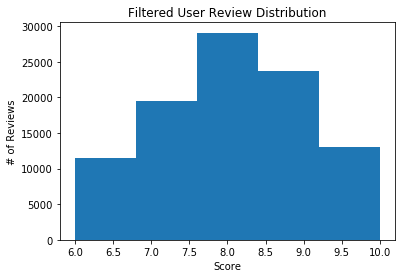

In [50]:
plt.hist(df.norm_score, bins=5)
plt.title("Filtered User Review Distribution")
plt.xlabel("Score")
plt.ylabel("# of Reviews")

# Setting up a pivot table

In [51]:
pivot = df.pivot_table(index='reviewer_id', columns='title', values='norm_score')
pivot.shape

(4462, 4411)

In [52]:
pivot.fillna(0).values
pivot.shape

(4462, 4411)

In [53]:
pivot.head()

title,007 Legends (PC),007: NightFire (PC),007: Quantum of Solace (PC),0RBITALIS (PC),10 Second Ninja (PC),"10,000,000 (PC)",1001 Spikes (PC),12 is Better Than 6 (PC),140 (PC),15 Days (PC),...,Zoo Tycoon: Marine Mania (PC),Zuma's Revenge! (PC),continue?9876543210 (PC),iRacing (PC),imprint-X (PC),inMomentum (PC),kill.switch (PC),nail'd (PC),rymdkapsel (PC),theHunter: Call of the Wild (PC)
reviewer_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
1,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,NaN,NaN,NaN,NaN,7.0,8.0,NaN,6.0


In [83]:
A = 3296 #The reviewer id that we want...
print df['reviewer_name'].where(df['reviewer_id'] == A).value_counts().index.values # get the name of "A" (hacky)
print
print pivot.iloc[A].dropna() #These are all reviews from reviewer_id "A"

['PStakhiv']

title
BioShock Infinite (PC)                             9.0
Dead Space 3 (PC)                                  7.0
Deus Ex: Human Revolution (PC)                    10.0
Dishonored (PC)                                    8.0
Dragon Age: Origins (PC)                           9.0
Far Cry 3 (PC)                                     9.0
Kingdoms of Amalur: Reckoning (PC)                 7.0
Mass Effect (PC)                                   9.0
Mass Effect 2 (PC)                                10.0
Mass Effect 2: Lair of the Shadow Broker (PC)      9.0
Mass Effect 3 (PC)                                 8.0
Mass Effect 3: Citadel (PC)                        7.0
Metro: Last Light (PC)                             9.0
Portal (PC)                                        9.0
Pro Evolution Soccer 2014 (PC)                     8.0
Remember Me (PC)                                   6.0
The Elder Scrolls IV: Oblivion (PC)                8.0
The Elder Scrolls V: Skyrim (PC)             

# ----------------------------------------------------------------------------------------

In [55]:
pivotsparse = sparse.csc_matrix(pivot.fillna(0).values)

In [56]:
pivot.fillna(0).shape

(4462, 4411)

In [57]:
print pivotsparse[800] #Scipy Sparse
print pivot.iloc[800].dropna()

  (0, 111)	6.0
  (0, 148)	7.0
  (0, 437)	7.0
  (0, 506)	7.0
  (0, 601)	6.0
  (0, 1076)	8.0
  (0, 1215)	8.0
  (0, 1457)	9.0
  (0, 1460)	6.0
  (0, 1461)	7.0
  (0, 1689)	7.0
  (0, 1836)	7.0
  (0, 2101)	6.0
  (0, 2183)	9.0
  (0, 2222)	8.0
  (0, 2223)	9.0
  (0, 2224)	8.0
  (0, 2225)	6.0
  (0, 2313)	8.0
  (0, 2445)	9.0
  (0, 2497)	7.0
  (0, 2539)	6.0
  (0, 2540)	6.0
  (0, 2542)	6.0
  (0, 2808)	10.0
  (0, 2810)	7.0
  (0, 2939)	6.0
  (0, 3947)	8.0
  (0, 4169)	9.0
title
Alan Wake's American Nightmare (PC)                      6.0
Alpha Protocol (PC)                                      7.0
BioShock Infinite: Burial at Sea - Episode One (PC)      7.0
Blues and Bullets - Episode 1: The End of Peace (PC)     7.0
Call of Duty: World at War (PC)                          6.0
Dishonored (PC)                                          8.0
Dying Light (PC)                                         8.0
Fallout: New Vegas (PC)                                  9.0
Fallout: New Vegas - Lonesome Road (PC)       

## Finding the User for tuning...

In [76]:
# gotta find the user...
name = 'Triggerhappy'
df[df['reviewer_name'].str.contains(name)]

,is_critic,reviewer_name,reviewer_score,url,title,norm_score,genre,reviewer_id
90452,0,Triggerhappy,9,bioshock-infinite,BioShock Infinite (PC),9,"Action, Shooter, First-Person, Sci-Fi, Arcade",3289
90453,0,Triggerhappy,8,borderlands-2,Borderlands 2 (PC),8,"Action, Shooter, First-Person, Sci-Fi, Arcade",3289
90454,0,Triggerhappy,6,endless-space,Endless Space (PC),6,"Strategy, Turn-Based, General, 4X",3289
90455,0,Triggerhappy,10,guild-wars-2,Guild Wars 2 (PC),10,"General, Role-Playing, Massively Multiplayer O...",3289
90456,0,Triggerhappy,9,jade-empire-special-edition,Jade Empire: Special Edition (PC),9,"Role-Playing, Action RPG, RPG",3289
90457,0,Triggerhappy,6,sid-meiers-civilization-v,Sid Meier's Civilization V (PC),6,"Strategy, Turn-Based, Historic, 4X",3289
90458,0,Triggerhappy,6,the-elder-scrolls-v-skyrim---dawnguard,The Elder Scrolls V: Skyrim - Dawnguard (PC),6,"Role-Playing, First-Person, Western-Style",3289


## Running the Model

In [84]:
# I set my 'X' value as my pivot table of the data.
# I am planning to feed the 'y' or user input into the dataframe to be saved among the others.
# This is so I can collect new reviews to be fed into the model.

X = pivotsparse
nbrs = NearestNeighbors(n_neighbors=6).fit(X)
distances, indices = nbrs.kneighbors(pivotsparse[3296]) #Input the desired user id here
print distances
print "-"*20
print indices

[[  0.          33.54101966  33.85262176  34.51086785  34.53983208
   34.55430509]]
--------------------
[[3296 3682 1585 3743 3729 3004]]


## Cleaning up the output

In [85]:
#indices are displayed as a list within a list
print indices[0]
print indices[0][0]
print indices[0][2]

[3296 3682 1585 3743 3729 3004]
3296
1585


In [86]:
sample_reviewer = indices[0][0]
suggested_reviewers = indices[0][1:]

print sample_reviewer
print suggested_reviewers

3296
[3682 1585 3743 3729 3004]


In [87]:
# Make a function to filter out titles already listed in our source reviewer...
def user_suggestions(ur, sr):
    usrTitles = []
    for t in pivot.iloc[ur].dropna().index:
        usrTitles.append(t)
    sugTitles = []
    for rec in sr:
        for t in pivot.iloc[rec].dropna().index:
            sugTitles.append(t)

    recommendations = [x for x in sugTitles if x not in usrTitles]

    return recommendations 

In [88]:
print 'Here are your Reviews:'
print "-"*40
print pivot.iloc[sample_reviewer].dropna()
print
print "*"*40
print "Here are recommendations from similar reviewers..."
print "*"*40
print
for i in user_suggestions(sample_reviewer, suggested_reviewers):
    print i

Here are your Reviews:
----------------------------------------
title
BioShock Infinite (PC)                             9.0
Dead Space 3 (PC)                                  7.0
Deus Ex: Human Revolution (PC)                    10.0
Dishonored (PC)                                    8.0
Dragon Age: Origins (PC)                           9.0
Far Cry 3 (PC)                                     9.0
Kingdoms of Amalur: Reckoning (PC)                 7.0
Mass Effect (PC)                                   9.0
Mass Effect 2 (PC)                                10.0
Mass Effect 2: Lair of the Shadow Broker (PC)      9.0
Mass Effect 3 (PC)                                 8.0
Mass Effect 3: Citadel (PC)                        7.0
Metro: Last Light (PC)                             9.0
Portal (PC)                                        9.0
Pro Evolution Soccer 2014 (PC)                     8.0
Remember Me (PC)                                   6.0
The Elder Scrolls IV: Oblivion (PC)               

In [89]:
# We're getting better result, but let's try filtering out users by a different method...